In [2]:
import os
import time
import ctypes

# A 3.0 - 3.1
Here I initially had trouble because I made a new Makefile that compiled the cyclecounter source file into C++. I checked the output of `readelf` and noticed the C++ name mangling. When I would try the below code I would get an error saying undefined symbol, but after I recompiled the cyclecounter source file as C everything was working well.

In [3]:
libpmu = ctypes.CDLL('./libpmu.so')

In [4]:
# intializing cpu cycle count
libpmu.init_counters(1,0)

cycle_count = libpmu.get_cyclecount()
print(f'Cycle count: {cycle_count}')

Cycle count: 1455372


In [5]:
libpmu.get_cyclecount()

75964862

# 3.2
After inserting the kernel module and editing the bootargs, I wrote a function that dispatched the fibonacci process with a configurable number of terms and on a configurable CPU for code reuse. It returns the time taken and the cycle count for the fibnoacci problem. I do acknowledge that time.time is not as good of a metric because it includes the overhead of the `os.system` function, but this is another caus to favor PMU cycle counts.

In [6]:
def run(cpu: int, fib: int):
    libpmu.init_counters(1,0)
    before_time = time.time()
    print(before_time)
    before_cycle = libpmu.get_cyclecount()
    os.system(f"taskset -c {cpu} echo {fib} | taskset -c {cpu} python3 ./fib.py")
    after_time = time.time()
    print(after_time)
    after_cycle = libpmu.get_cyclecount()
    return after_time - before_time, after_cycle - before_cycle

In [7]:
run(1, 10)

1769825820.1405883
How many terms? time spent: 0.00034165382385253906
1769825820.459105


(0.31851673126220703, 325175782)

In [ ]:
run(0, 10)

## Running Trials

Here I run 5 trials for n fibonacci tterms where 0 <= n <= 30

In [32]:
trials_cpu_0 = [
    [run(0, i) for _ in range(5)]
    for i in range(30)
]

trials_cpu_1 = [
    [run(1, i) for _ in range(5)]
    for i in range(30)    
]

How many terms? Please enter a positive integer
time spent: 2.9325485229492188e-05
How many terms? Please enter a positive integer
time spent: 2.8371810913085938e-05
How many terms? Please enter a positive integer
time spent: 2.8371810913085938e-05
How many terms? Please enter a positive integer
time spent: 2.9087066650390625e-05
How many terms? Please enter a positive integer
time spent: 3.075599670410156e-05
How many terms? time spent: 1.3828277587890625e-05
How many terms? time spent: 1.4066696166992188e-05
How many terms? time spent: 1.4066696166992188e-05
How many terms? time spent: 1.3828277587890625e-05
How many terms? time spent: 1.4543533325195312e-05
How many terms? time spent: 2.0265579223632812e-05
How many terms? time spent: 1.9311904907226562e-05
How many terms? time spent: 1.9073486328125e-05
How many terms? time spent: 1.9550323486328125e-05
How many terms? time spent: 2.0265579223632812e-05
How many terms? time spent: 2.384185791015625e-05
How many terms? time spent: 2

How many terms? time spent: 2.2411346435546875e-05
How many terms? time spent: 2.2411346435546875e-05
How many terms? time spent: 2.2649765014648438e-05
How many terms? time spent: 2.384185791015625e-05
How many terms? time spent: 2.6941299438476562e-05
How many terms? time spent: 2.6702880859375e-05
How many terms? time spent: 2.7179718017578125e-05
How many terms? time spent: 2.6702880859375e-05
How many terms? time spent: 2.8371810913085938e-05
How many terms? time spent: 3.62396240234375e-05
How many terms? time spent: 3.457069396972656e-05
How many terms? time spent: 3.5762786865234375e-05
How many terms? time spent: 3.504753112792969e-05
How many terms? time spent: 3.528594970703125e-05
How many terms? time spent: 4.8160552978515625e-05
How many terms? time spent: 4.601478576660156e-05
How many terms? time spent: 4.553794860839844e-05
How many terms? time spent: 4.887580871582031e-05
How many terms? time spent: 4.649162292480469e-05
How many terms? time spent: 6.699562072753906e-

In [33]:
len(trials_cpu_0)

30

## Saving results
It was kind of a pain to set up the assignment and have to do all the kernel module and bootargs stuff, so I just wrote the results to a text file so that I could pick up where I left off easier

In [37]:
# with open("trials_cpu_0.txt", "w+") as f:
#     for n in trials_cpu_0:
#         for individual in n:
#             f.write(str(individual))
#             f.write(" ")
#         f.write("\n")

# with open("trials_cpu_1.txt", "w+") as f:
#     for n in trials_cpu_1:
#         for individual in n:
#             f.write(str(individual))
#             f.write(" ")
#         f.write("\n")

## Parsing
This function is just to read and get the data into the same format as it was exported.

In [1]:
def read_trials(cpu_no: int):
    trials = []
    with open(f"trials_cpu_{cpu_no}.txt") as f:
        txt = f.read().strip()
    lines = txt.split('\n')
    for line in lines:
        row = []
        tuples = line.strip().split(')')
        for t in tuples:
            if t == '':
                continue
            field1, field2 = t[1:-1].split(',')
            field1 = float(field1.replace('(', '').replace(')', ''))
            field2 = int(field2.replace('(', '').replace(')', ''))
            row.append((field1, field2))
        trials.append(row)
    return trials

In [53]:
trials0 = read_trials(0)
trials1 = read_trials(1)

In [3]:
import matplotlib.pyplot as plt

## Statistical Calculation
Here I compute means

In [4]:
mean_times_trial_0 = [sum([x[0] for x in trial]) / len(trial) for trial in trials0]
mean_cycles_trial_0 = [sum([x[1] for x in trial]) / len(trial) for trial in trials0]

mean_times_trial_1 = [sum([x[0] for x in trial]) / len(trial) for trial in trials1]
mean_cycles_trial_1 = [sum([x[1] for x in trial]) / len(trial) for trial in trials1]

This next cell computes the standard deviation and then error of a 5-trial run of a fixed amount of fibonacci terms, then it uses that to calculate the error. Then there's a functoin that does it for the whole set of trials

In [34]:
def err(run: list, mean: float):
    sd = pow(sum([pow(x-mean, 2) for x in run])/len(run), 0.5)
    error = sd / pow(len(run), 0.5)
    return error

    
def err_for_run(trials, means):
    errs = []
    for run, mean in zip(trials, means):
        e = err(run, mean)
        errs.append(e)
    return errs

In [35]:
error_times_trial_0 = err_for_run([[x[0] for x in trial] for trial in trials0], mean_times_trial_0)
error_cycles_trial_0 = err_for_run([[x[1] for x in trial] for trial in trials0], mean_cycles_trial_0)

error_times_trial_1 = err_for_run([[x[0] for x in trial] for trial in trials1], mean_times_trial_1)
error_cycles_trial_1 = err_for_run([[x[1] for x in trial] for trial in trials1], mean_cycles_trial_1)

## Plotting

Text(0.5, 1.0, 'Terms vs Run Time on Non-Isolated CPU 0')

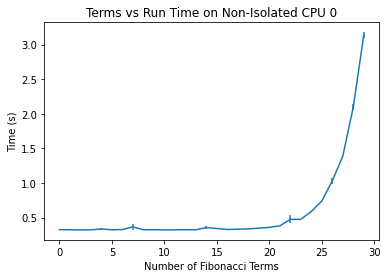

In [42]:
plt.errorbar(list(range(30)), mean_times_trial_0, error_times_trial_0)
plt.xlabel("Number of Fibonacci Terms")
plt.ylabel("Time (s)")
plt.title("Terms vs Run Time on Non-Isolated CPU 0")


Text(0.5, 1.0, 'Terms vs Run Time on Isolated CPU 1')

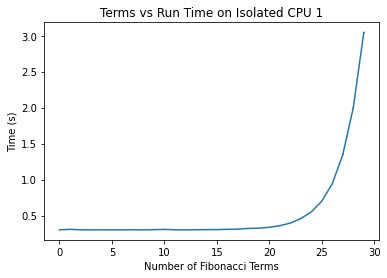

In [43]:
plt.errorbar(list(range(30)), mean_times_trial_1, error_times_trial_1)
plt.xlabel("Number of Fibonacci Terms")
plt.ylabel("Time (s)")
plt.title("Terms vs Run Time on Isolated CPU 1")


Text(0.5, 1.0, 'Terms vs Cycle Count on Non-Isolated CPU 0')

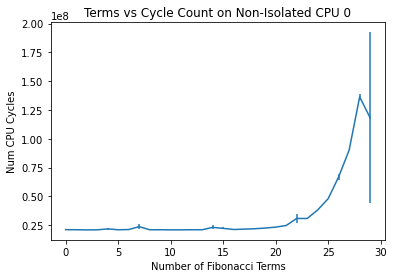

In [44]:
plt.errorbar(list(range(30)), mean_cycles_trial_0, error_cycles_trial_0)
plt.xlabel("Number of Fibonacci Terms")
plt.ylabel("Num CPU Cycles")
plt.title("Terms vs Cycle Count on Non-Isolated CPU 0")


Text(0.5, 1.0, 'Terms vs Cycle Count on Isolated CPU 1')

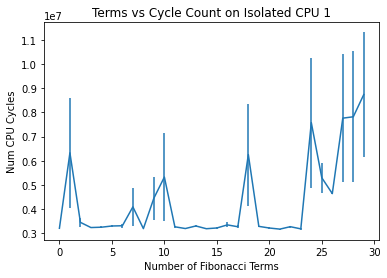

In [46]:
plt.errorbar(list(range(30)), mean_cycles_trial_1, error_cycles_trial_1)
plt.xlabel("Number of Fibonacci Terms")
plt.ylabel("Num CPU Cycles")
plt.title("Terms vs Cycle Count on Isolated CPU 1")


In [41]:
error_cycles_trial_1

[4984.166846324468,
 2285955.504102013,
 177133.30095464262,
 18598.104359315763,
 38735.33939482136,
 61008.7496941873,
 91829.59987559567,
 775694.6173050113,
 4907.563121550246,
 887748.177261926,
 1832420.738881199,
 45077.99767567322,
 7641.0519516621525,
 48049.67536173371,
 3434.9329239448034,
 22847.6203774485,
 101815.2201468523,
 64266.33789373718,
 2103791.3033972434,
 35568.977158642054,
 28049.57480462048,
 17963.110223789194,
 46449.895329053215,
 43567.71568250968,
 2691711.732634013,
 614777.9127541651,
 34429.10076850686,
 2635480.4360765433,
 2710894.4759952184,
 2573405.914177598]

## Normalizing cycle count into a time
Whenever I did and sort of `lscpu` or similar command, all I got was BogoMIPS. After doing some reading, for the ARM CPU that is on the PYNQ board, the BogoMIPS is about half of the clock speed in MHz.

In [60]:
# https://en.wikipedia.org/wiki/BogoMips
# MHz ~= 2 * BogoMips on Arm9
bogomips = 325
# instructions per second
hz = 325 * 1_000_000 * 2

period = 1 / hz * 10

Text(0.5, 1.0, 'Terms vs Run Time on Non-Isolated CPU 0')

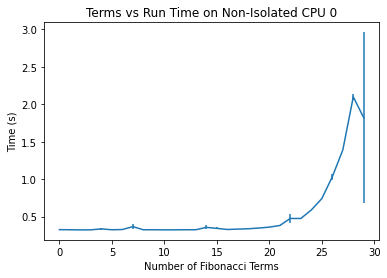

In [61]:
trials0 = read_trials(0)
trials1 = read_trials(1)

trials0 = [[(x[0], x[1]*period) for x in trial] for trial in trials0]
trials1 = [[(x[0], x[1]*period) for x in trial] for trial in trials1]

mean_times_trial_0 = [sum([x[0] for x in trial]) / len(trial) for trial in trials0]
mean_cycles_trial_0 = [sum([x[1] for x in trial]) / len(trial) for trial in trials0]

mean_times_trial_1 = [sum([x[0] for x in trial]) / len(trial) for trial in trials1]
mean_cycles_trial_1 = [sum([x[1] for x in trial]) / len(trial) for trial in trials1]

error_cycles_trial_0 = err_for_run([[x[1] for x in trial] for trial in trials0], mean_cycles_trial_0)

error_cycles_trial_1 = err_for_run([[x[1] for x in trial] for trial in trials1], mean_cycles_trial_1)

plt.errorbar(list(range(30)), mean_cycles_trial_0, error_cycles_trial_0)
plt.xlabel("Number of Fibonacci Terms")
plt.ylabel("Time (s)")
plt.title("Terms vs Run Time on Non-Isolated CPU 0")



Text(0.5, 1.0, 'Terms vs Run Time on Isolated CPU 1')

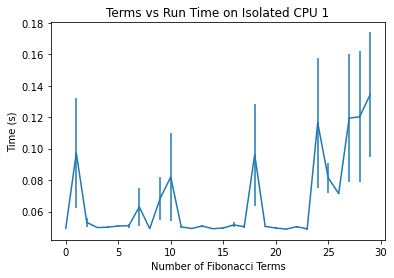

In [62]:
plt.errorbar(list(range(30)), mean_cycles_trial_1, error_cycles_trial_1)
plt.xlabel("Number of Fibonacci Terms")
plt.ylabel("Time (s)")
plt.title("Terms vs Run Time on Isolated CPU 1")


In [63]:
trials0

[[(0.32262444496154785, 0.3226417384615385),
  (0.3270397186279297, 0.3270594307692308),
  (0.32377004623413086, 0.3237896769230769),
  (0.3346714973449707, 0.3346919230769231),
  (0.32274770736694336, 0.3227682769230769)],
 [(0.32554125785827637, 0.3255615538461539),
  (0.32265305519104004, 0.32267193846153847),
  (0.3240487575531006, 0.3240703230769231),
  (0.32274508476257324, 0.3227627230769231),
  (0.3299441337585449, 0.32996529230769234)],
 [(0.3231775760650635, 0.3231956),
  (0.32235169410705566, 0.3223713076923077),
  (0.3232121467590332, 0.32323384615384615),
  (0.32303643226623535, 0.3230558),
  (0.3228902816772461, 0.3229123076923077)],
 [(0.32550787925720215, 0.3255273230769231),
  (0.3247826099395752, 0.32480275384615387),
  (0.32285022735595703, 0.3228714307692308),
  (0.3231816291809082, 0.3232023230769231),
  (0.3235328197479248, 0.3235522307692308)],
 [(0.32218360900878906, 0.3222039230769231),
  (0.3233473300933838, 0.3233682),
  (0.3223104476928711, 0.322331230769230

In [67]:
mean_cycles_trial_1

[0.049373596923076926,
 0.09732188307692308,
 0.053131163076923074,
 0.04984270769230769,
 0.0500554276923077,
 0.05082208615384616,
 0.05098264923076924,
 0.06297094461538462,
 0.049158141538461535,
 0.0685038276923077,
 0.08192733846153846,
 0.05031551384615385,
 0.049208206153846155,
 0.05084524,
 0.04909551076923078,
 0.04956726461538461,
 0.05152678153846154,
 0.050353510769230767,
 0.09619411076923078,
 0.050591473846153846,
 0.049542646153846154,
 0.048843058461538455,
 0.05038303076923077,
 0.049003766153846155,
 0.11650918461538462,
 0.08149576307692308,
 0.07141707076923078,
 0.11937488615384617,
 0.12023325846153847,
 0.13438396923076923]